<a href="https://colab.research.google.com/github/paramansh/TimeSeries/blob/master/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install arch
!pip install pandas-datareader

     |████████████████████████████████| 716kB 9.6MB/s 


In [0]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from google.colab import files

In [0]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', save=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        # qq_ax = plt.subplot2grid(layout, (2, 0))
        # pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)  # alpha: confidence interval for the given level, where std. dev. is computed acc. to
                                                                    # Bartlett's Formula
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        # sm.qqplot(y, line='s', ax=qq_ax)
        # qq_ax.set_title('QQ Plot')        
        # scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        if save is not None:
          fname = save + '.png'
          plt.savefig(fname)
          files.download(fname)

In [0]:
from scipy.stats import norm

def turning_point_test(y, alpha=0.05):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    y = y.values
    n = y.shape[0]
    y = np.reshape(y, n)

    Q = 0
    for i in range(1, n-1):
        if y[i-1] < y[i] and y[i] > y[i+1]:
            Q += 1
        elif y[i-1] > y[i] and y[i] < y[i+1]:
            Q += 1
    
    mu = 2 * (n-2)/3
    var = (16 * n - 29)/90
    Z = (Q - mu)/np.sqrt(var)

    if abs(Z) > norm.ppf(1 - alpha/2):
        return False
    else:
        return True

In [0]:
# Fitting ARIMA model using grid search over model order and parameter estimation via MLE, comparing models on AIC.

def _get_best_ARIMA(TS, max_order=5, max_diff=2):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(max_order)
    d_rng = range(max_diff)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [0]:
# Fitting ARMA model using grid search over model order and parameter estimation via MLE, comparing models on AIC.
# MLE estimation by default, using students T dist for errors, since financial returns are often heavily tailed.

def _get_best_GARCH(TS, max_order=5):
    best_aic = np.inf
    best_order = None
    best_dist = None
    best_mdl = None

    pq_rng = range(max_order)
    for dist in ['Normal', 'StudentsT']:
        for i in pq_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = arch_model(df['lrets'], p=i, o=0, q=j, dist=dist).fit(disp='off')
                    tmp_aic = 2 * len(tmp_mdl.params) - 2 * tmp_mdl.loglikelihood
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, j)
                        best_dist = dist
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {} | errors ~ {}'.format(best_aic, best_order, best_dist))
    return best_aic, best_order, best_mdl

In [0]:
import datetime as dt
import pandas_datareader.data as web

start = dt.datetime(2014, 12, 31)
end = dt.datetime(2017, 12, 31)

df = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
df = df[['Adj Close']].dropna()

# log returns
df['lrets'] = np.log(df/df.shift(1))
df = df.dropna()

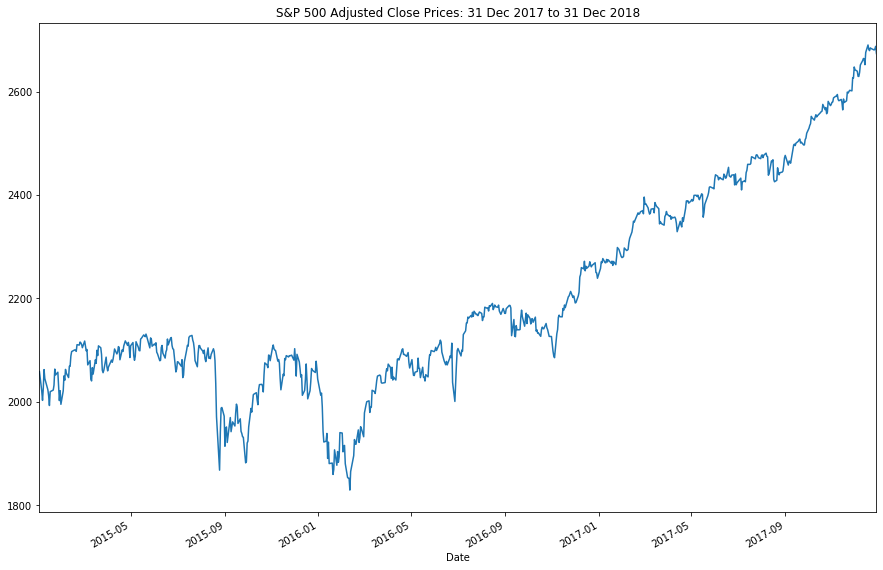

In [0]:
title = 'S&P 500 Adjusted Close Prices: {} to {}'.format(start.strftime('%d %b %Y'), end.strftime('%d %b %Y'))
df['Adj Close'].plot(figsize=(15, 10), title=title)
# plt.savefig('adj_close.png')
# files.download('adj_close.png')

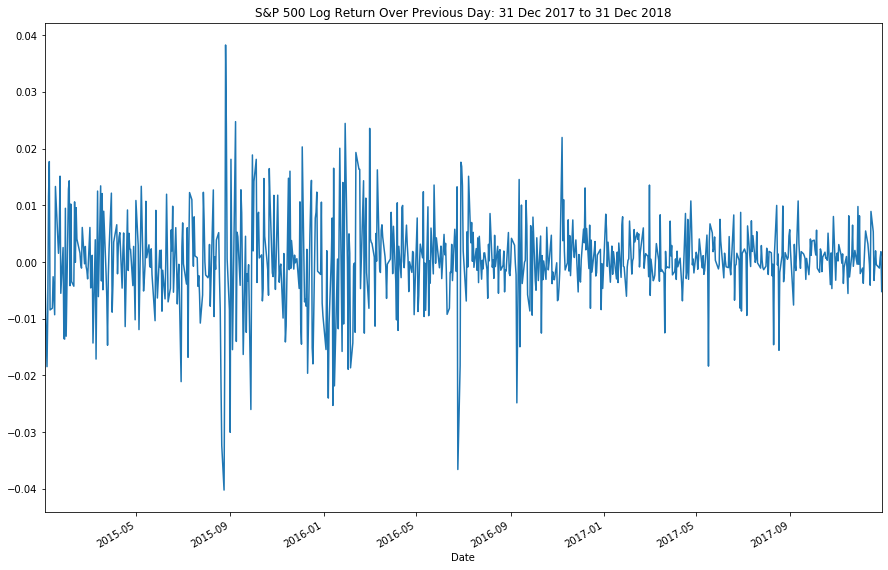

In [0]:
title = 'S&P 500 Log Return Over Previous Day: {} to {}'.format(start.strftime('%d %b %Y'), end.strftime('%d %b %Y'))
df['lrets'].plot(figsize=(15, 10), title=title)
# plt.savefig('log_returns.png')
# files.download('log_returns.png')

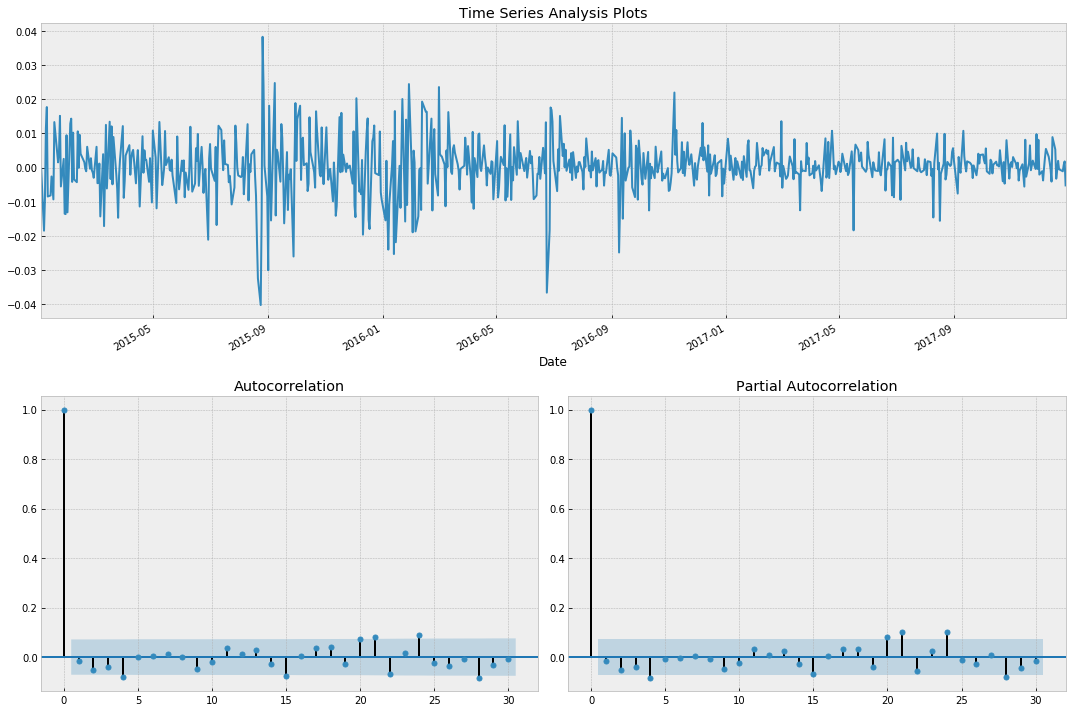

In [0]:
tsplot(df['lrets'], lags=30)

In [0]:
_, order, model = _get_best_ARIMA(df['lrets'], max_order=3)
# model = smt.ARIMA(df['lrets'], order=(2, 0, 1)).fit(method='mle', trend='nc')
print(model.summary())

aic: -5188.36035 | order: (2, 0, 1)
                              ARMA Model Results                              
Dep. Variable:                  lrets   No. Observations:                  755
Model:                     ARMA(2, 1)   Log Likelihood                2598.180
Method:                           mle   S.D. of innovations              0.008
Date:                Tue, 12 Nov 2019   AIC                          -5188.360
Time:                        06:17:20   BIC                          -5169.853
Sample:                             0   HQIC                         -5181.231
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.lrets     0.6999      0.164      4.257      0.000       0.378       1.022
ar.L2.lrets    -0.0508      0.040     -1.274      0.203      -0.129       0.027
ma.L1.lrets 

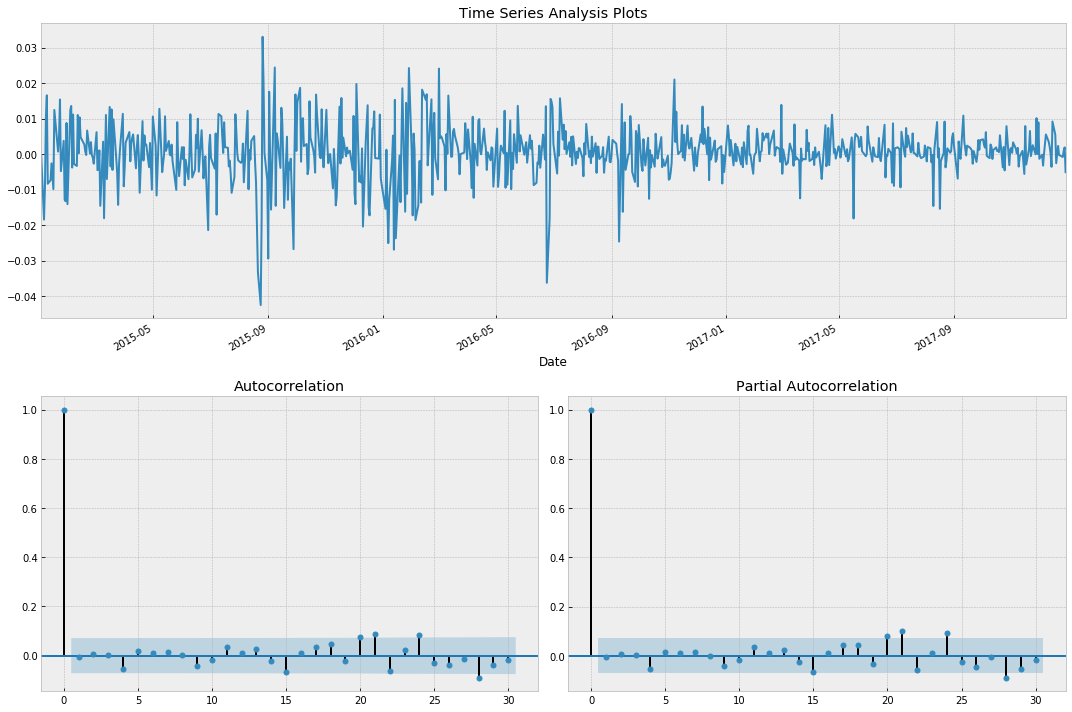

In [0]:
tsplot(model.resid, lags=30, save='gspc_rets_resid')

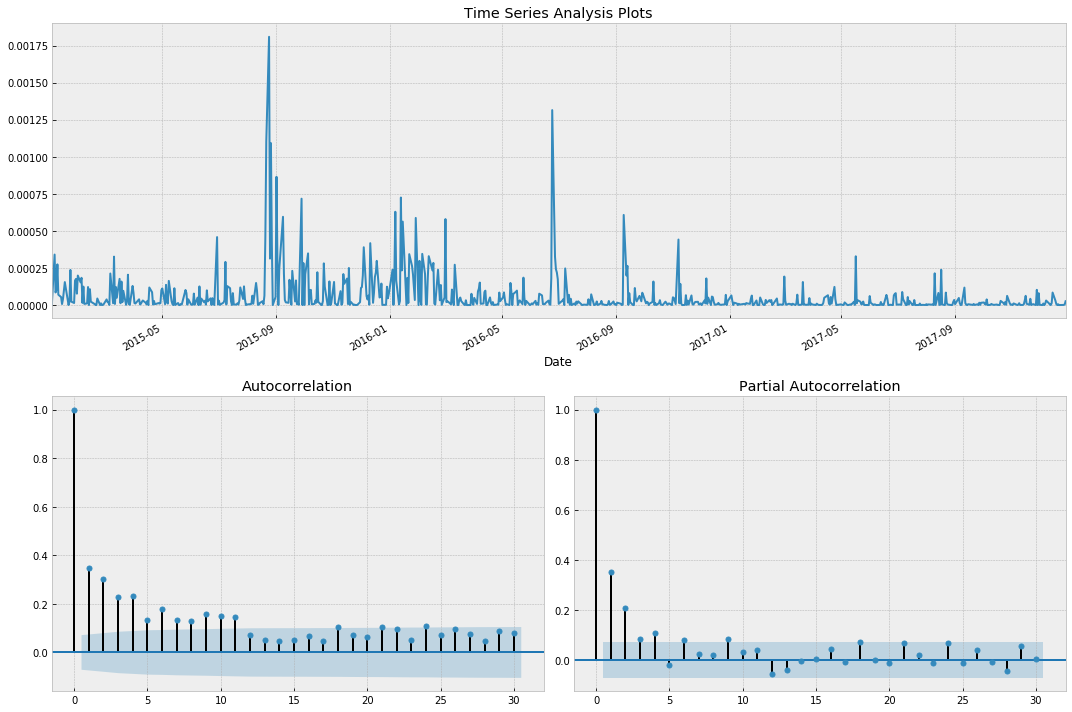

In [0]:
tsplot(model.resid**2, lags=30, save='gspc_rets_resid_sq')

In [0]:
# turning_point_test(model.resid, alpha=0.1)

In [0]:
# model_g = arch_model(model.resid, p=1, o=0, q=1, dist='Normal').fit(disp='off')
_, order_g, model_g = _get_best_GARCH(model.resid)

print(model_g.summary())

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

aic: -5393.60446 | order: (1, 1) | errors ~ Normal
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  lrets   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                2700.80
Distribution:                  Normal   AIC:                          -5393.60
Method:            Maximum Likelihood   BIC:                          -5375.10
                                        No. Observations:                  755
Date:                Tue, Nov 12 2019   Df Residuals:                      751
Time:                        05:55:47   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu     

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [0]:
# Forescast Testing

start = dt.datetime(2017, 12, 31)
end = dt.datetime(2018, 12, 31)

test = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
test = test[['Adj Close']].dropna()

# log returns
test['lrets'] = np.log(test/test.shift(1))
test = test.dropna()
horizon = test.shape[0]

pred_g = model_g.forecast(horizon=horizon, start=test.first_valid_index(), align='origin')

# **Simulation**

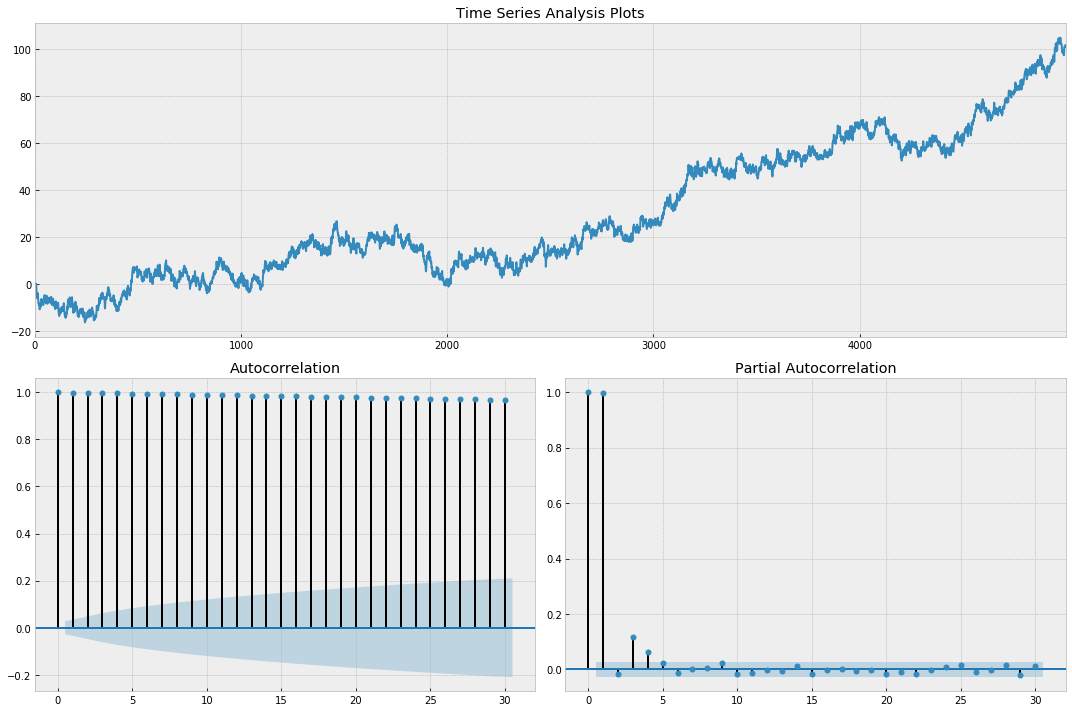

In [0]:
# ARIMA (2, 1, 1)
alphas = np.array([0.5, -0.25])
betas = np.array([-0.5])

pAR = np.r_[1, -alphas]
pMA = np.r_[1, betas]

y = smt.arma_generate_sample(ar=pAR, ma=pMA, nsample=5000, burnin=2000).cumsum()
tsplot(y, lags=30)

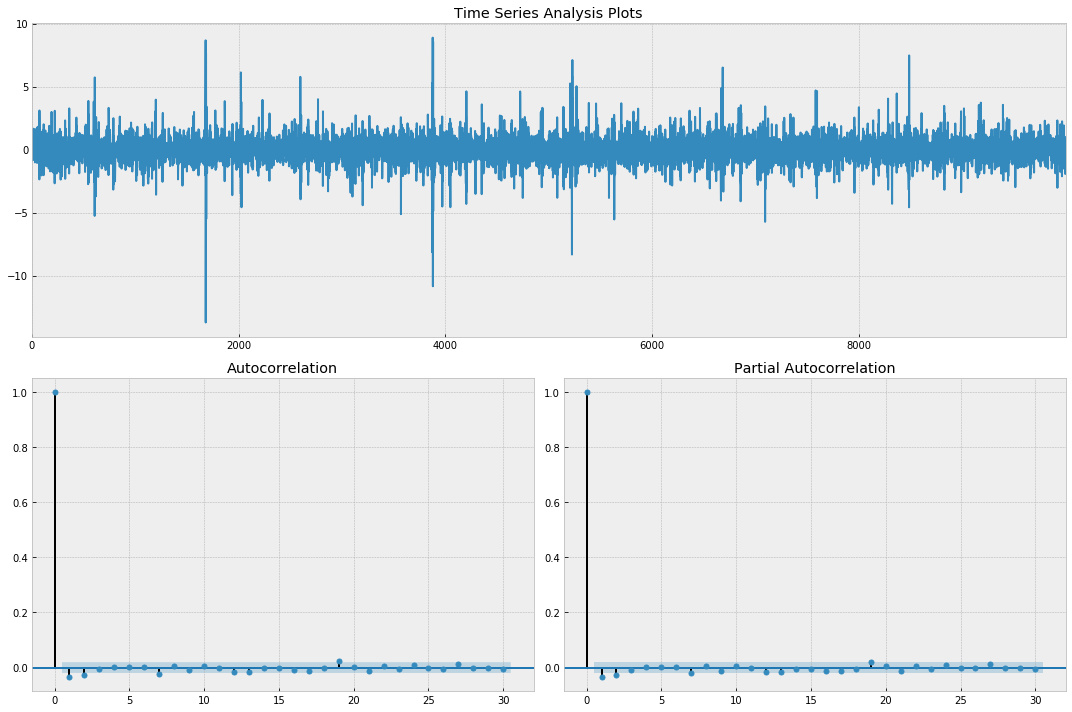

In [0]:
# Constant mean GARCH(1, 1)

N = 10000
burn = 2000

omega = 0.2
alpha = 0.5
beta = 0.3

w = np.random.normal(size=N+burn + 1)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, N+burn + 1):
    sigsq[i] = omega + alpha * (eps[i-1]**2) + beta * sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps[burn+1:], lags=30, save='garch11_sim')

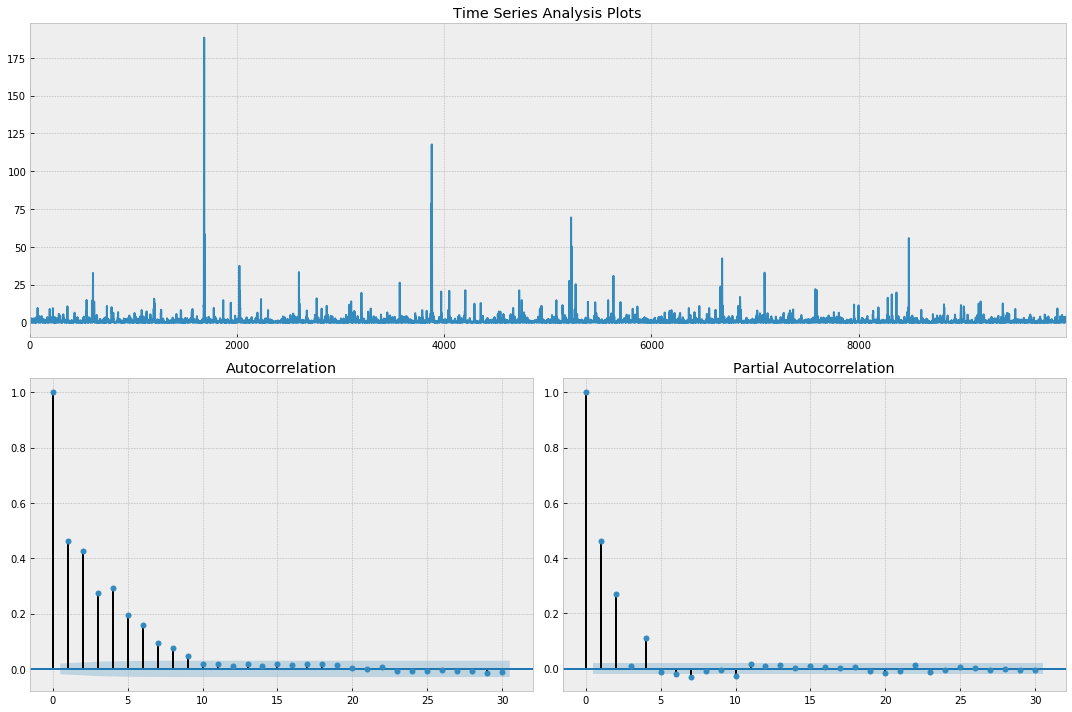

In [0]:
tsplot(eps[burn+1:]**2, lags=30, save='garch11_sq_sim')

In [0]:
# Additive model: ARIMA(2, 1, 1) and GARCH(1, 1)

y = np.zeros(N+burn + 1)

for i in range(1, N+burn + 1):
    y[i] = 0.5 * y[i-1] - 0.25 * y[i-2] + eps[i] - 0.5 * eps[i-1]

Y = y[burn+1:].cumsum()

_, order, model = _get_best_ARIMA(Y, max_order=4)

aic: 28574.30459 | order: (2, 1, 1)


MessageError: ignored

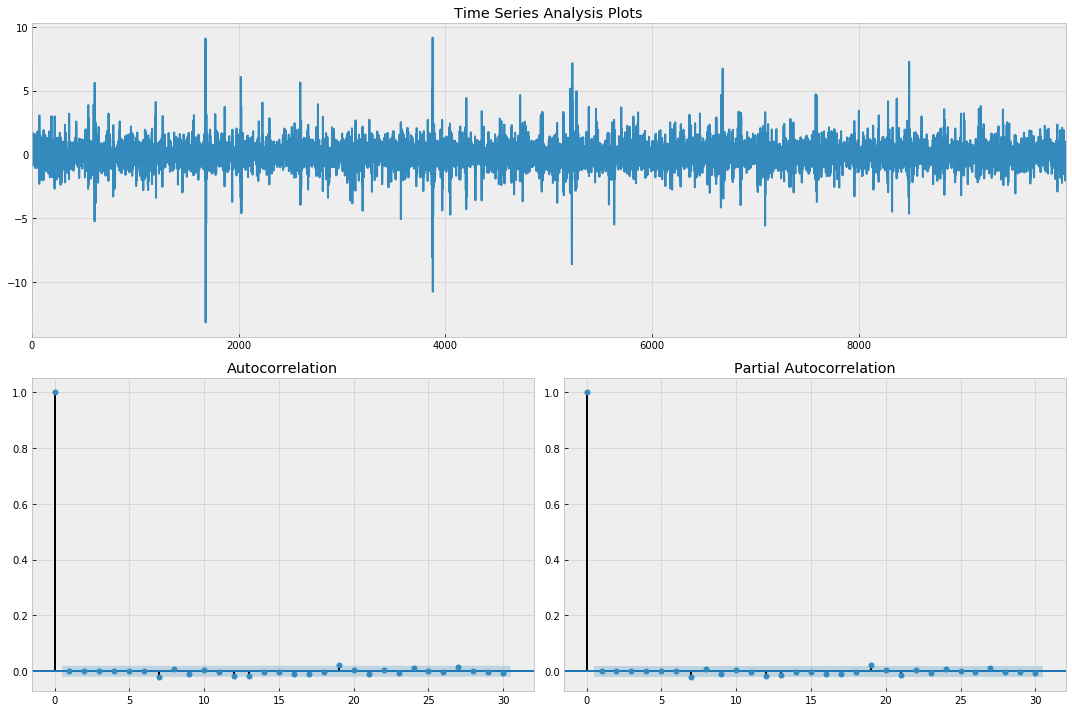

In [0]:
tsplot(model.resid, lags=30, save='resid_sim')

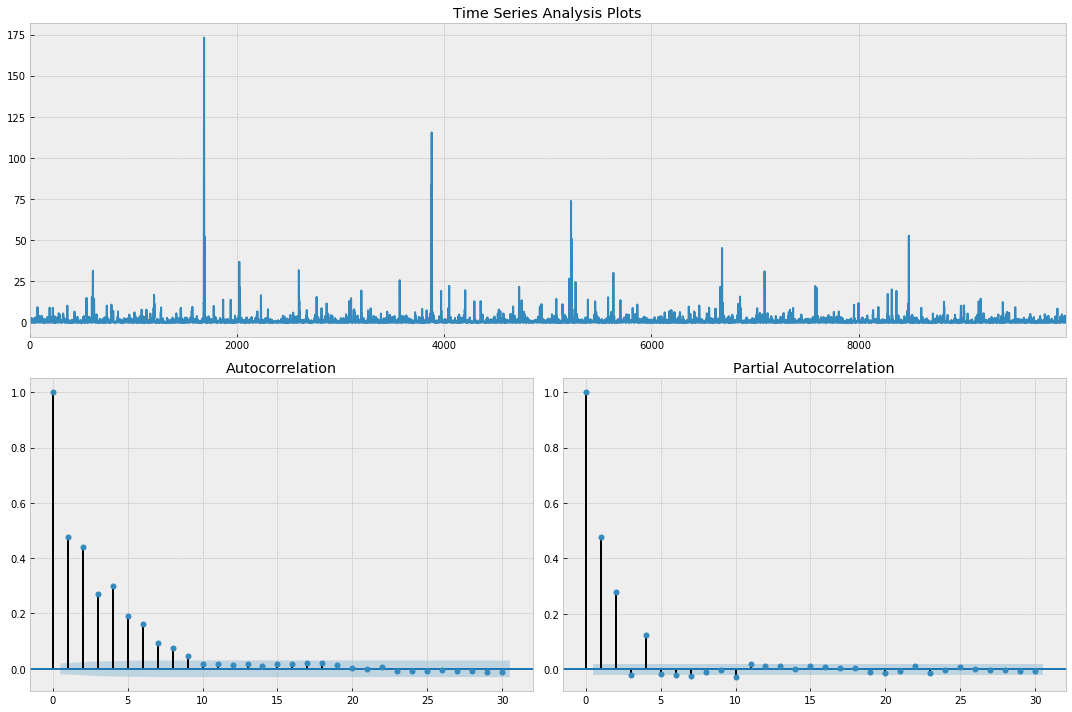

In [0]:
tsplot(model.resid**2, lags=30, save='resid_sq_sim')

In [0]:
turning_point_test(model.resid, alpha=0.05)

False

In [0]:
# _, order_g, model_g = _get_best_GARCH(model.resid, max_order=2)
model_g = arch_model(model.resid, p=1, q=1, dist='Normal').fit(update_freq=5)

print(model_g.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 12391.451910507843
Iteration:     10,   Func. Count:     70,   Neg. LLF: 12280.870581038638
Iteration:     15,   Func. Count:    100,   Neg. LLF: 12279.907632900138
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12279.90763289995
            Iterations: 15
            Function evaluations: 100
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12279.9
Distribution:                  Normal   AIC:                           24567.8
Method:            Maximum Likelihood   BIC:                           24596.7
                                        No. Observations:                 9999
Date:            